# Analysis of the online model

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
results_filename = '../data/batch_online_paper_r_s8_dt07-18_01-20-21.json'

with open(results_filename) as file:
    results_data = json.load(file)

## Single model analysis

In [3]:
results = results_data[0]
for task in results['model']['tasks']:
    if 'auction time' not in task:
        task['auction time'] = 0

### Task arrival over time

Text(0.5, 1.0, 'Task Arrival at each time step')

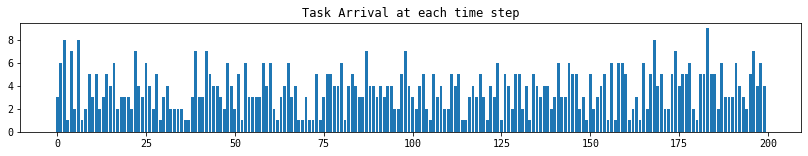

In [4]:
arrival_num = [
    sum(task['auction time'] == arrival_time for task in results['model']['tasks']) 
    for arrival_time in range(200)
]

_, ax_task_arrival = plt.subplots(figsize=(14, 2))
ax_task_arrival.bar(np.arange(200), arrival_num)
ax_task_arrival.set_title('Task Arrival at each time step')

### Server resource usage

KeyError: 'Online Flexible Optimal'

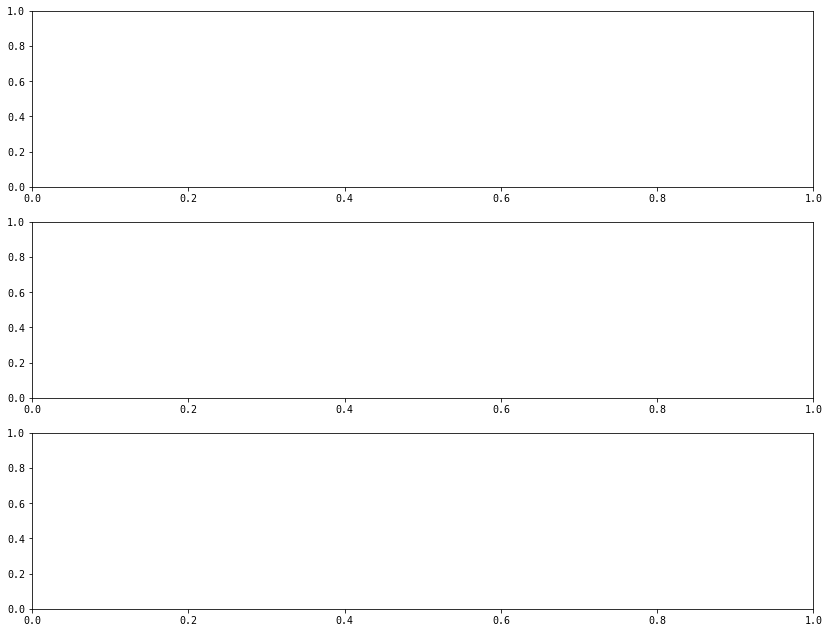

In [5]:
resource_usage_fig, (ax_server_storage_usage, ax_computation_usage, ax_bandwidth_usage) = plt.subplots(3, 1, figsize=(14, 11))
ax_server_storage_usage.bar(np.arange(200), results['Online Flexible Optimal']['server storage used']['server 0'])
ax_server_storage_usage.set_title('Server Storage Usage')

ax_computation_usage.bar(np.arange(200), results['Online Flexible Optimal']['server computation used']['server 0'])
ax_computation_usage.set_title('Server Computation Usage')

ax_bandwidth_usage.bar(np.arange(200), results['Online Flexible Optimal']['server bandwidth used']['server 0'])
ax_bandwidth_usage.set_title('Server Bandwidth Usage')

## batch results

In [ ]:
batch_fig, ax_batches = plt.subplots(1, 5, figsize=(13, 8))
result_names = ['batch length 1', 'batch length 3', 'batch length 5', 'batch length 7', 'batch length 10', 'batch length 15']
algos = [name for name in results['batch length 1']]
for name, ax in zip(result_names, ax_batches):
    ax.barh(algos, [results[name][algo]['social welfare'] for algo in algos])
    ax.set_title(name)
    
for ax in ax_batches[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

In [ ]:
print(results['Online Flexible Optimal']['social welfare'])
print(results['Online Fixed Optimal']['social welfare'])

In [ ]:
print([str(r['Online Fixed Optimal']['social welfare']) for r in results_data])
print([str(r['Online Flexible Optimal']['social welfare']) for r in results_data])